In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch

# setting some seeds so that the results are deterministic
def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

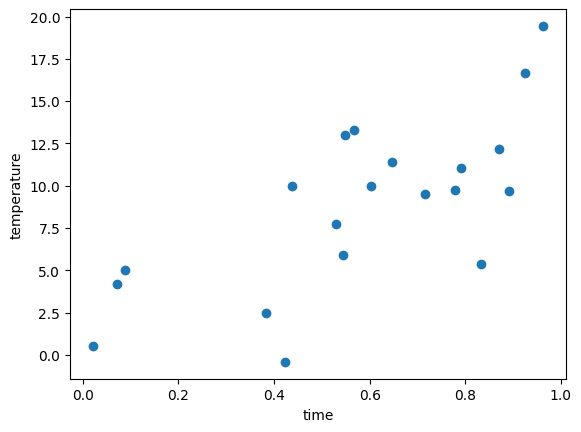

In [3]:
def generate_data(data_size=100):
    x_data = np.random.rand(data_size)
    y_data = 10 * x_data + 3 + 3.0 * np.random.normal(size=data_size)
    return x_data, y_data

def plot_data(x_data, y_data, regressor=None, draw_l2_lines=False):
    plt.figure()
    plt.scatter(x_data, y_data)
    if regressor is not None:
        plt.plot(x_data, regressor(x_data), color='red')
    if draw_l2_lines:
        # drop vertical lines from the data points to the regression line
        for x, y in zip(x_data, y_data):
            plt.plot([x, x], [y, regressor(x)], color='gray')
    plt.xlabel('time')
    plt.ylabel('temperature')
    plt.show()
    
def plot_loss(losses):
    plt.figure()
    plt.plot(losses)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()

x_data, y_data = generate_data(20)
plot_data(x_data, y_data)

Okay, now we are going to perform linear regression via gradient descent. 
Our generic formulation of the problem is that we have some prediction function $f_\theta(x)$ and we'd like to minimize some loss $L(y, f_\theta(x))$ where $y$ is the true value and $x$ is the input. In this case, we are going to perform linear regression. So in this case, our $\theta = (a, b)$ and our prediction function is:
$$\hat{y} = a x + b$$
where $a$ and $b$ are the parameters we want to find. Our loss function is going to be the mean squared error:
$$L = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$
where $n$ is the number of samples in the training set. Why this loss? Well, you can prove that if the system you're predicting is a linear system with Gaussian noise then this is the Bayes-optimal predictor. We want to minimize this loss function. Now, this problem actually has an optimal explicit solution but since this is prep for deep learning, we're going to solve this via gradient descent. 

**Warning: you should not use gradient descent for linear regression in practice. If you do this in a job interview, people will become very confused.**

First, lets plug in our predictor into the loss function:
$$L = \frac{1}{n} \sum_{i=1}^{n} (y_i - (a x_i + b))^2$$

The gradient of the loss function with respect to the parameter a is:
$$\frac{\partial L}{\partial a} = \frac{2}{n} \sum_{i=1}^{n} -x_i (y_i - \hat{y}_i)$$
and with respect to b is:
$$\frac{\partial L}{\partial b} = \frac{2}{n} \sum_{i=1}^{n} -(y_i - \hat{y}_i)$$

So the idea of gradient descent here is that we will pick some learning rate $\alpha$ and update our parameters as follows:
$$a = a - \alpha \frac{\partial L}{\partial a}$$
$$b = b - \alpha \frac{\partial L}{\partial b}$$

Okay, now lets actually do this out. We will start with some random values for $a$ and $b$ and then update them using the above equations. We will do this for 1000 iterations.

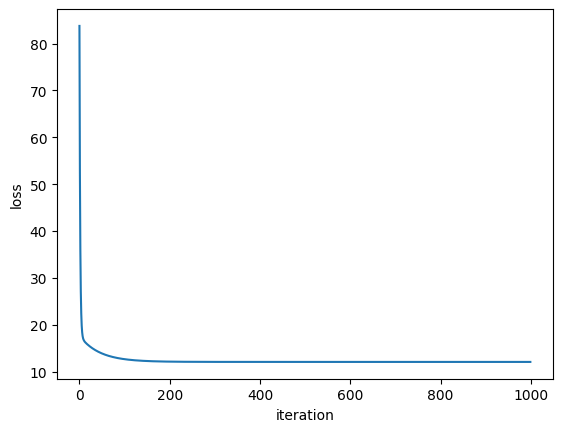

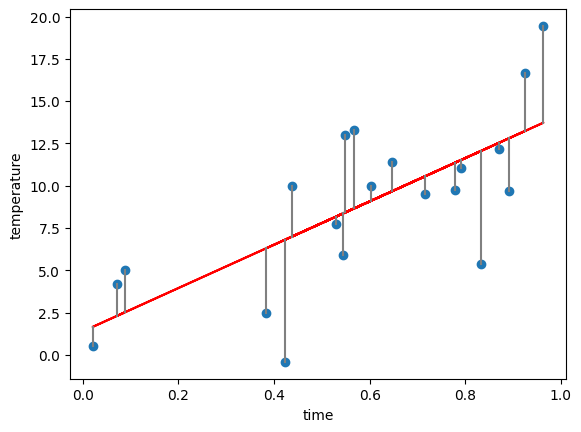

In [4]:
a = np.random.rand()
b = np.random.rand()
num_iters = 1000
learning_rate = 0.1
linear_loss_tracker = []
# Lets also track a and b every 200 steps so that we can plot how they evolve over time
a_tracker = []
b_tracker = []
for i in range(num_iters):
    y_pred = a * x_data + b
    error = (y_data - y_pred)
    loss = (error ** 2).mean()
    a_grad = -2 * (error * x_data).mean()
    b_grad = -2 * error.mean()
    a = a - learning_rate * a_grad
    b = b - learning_rate * b_grad
    linear_loss_tracker.append(loss)
    if i % 200 == 0:
        a_tracker.append(a)
        b_tracker.append(b)

plot_loss(linear_loss_tracker)
# now lets plot our predictions over the data
plot_data(x_data, y_data, lambda x: a * x + b, draw_l2_lines=True)


Okay, now lets do the same thing but with a neural network, just to get some practice. First, we'll implement linear regression in torch. In this case, this is exactly analogous to what we did above. We'll create a linear layer with one input and one output. We'll then create a loss function and an optimizer. We'll then do the same thing as above but with torch tensors.

took 0.2793102264404297 seconds


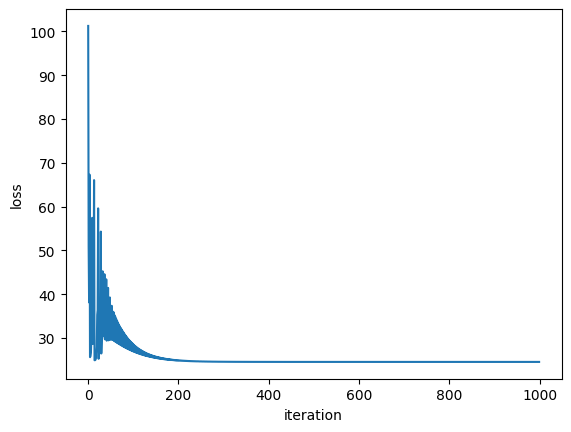

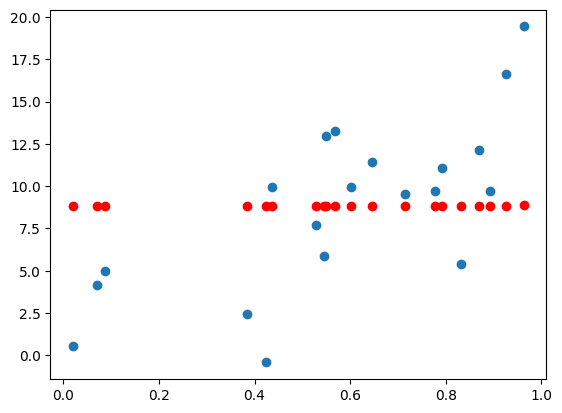

In [19]:
# class LinearRegressionModel(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.a = torch.nn.Parameter(torch.rand(1))
#         self.b = torch.nn.Parameter(torch.rand(1))
#         self.c = torch.nn.Parameter(torch.rand(1))

#     def forward(self, x):
#         return self.d * x * x * x + self.a * x * x + self.b * x + self.c

# model = LinearRegressionModel()


class BabyNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = torch.nn.ModuleList([
            torch.nn.Linear(1, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1)
        ])
    def forward(self, x_data):
        for layer in self.nn:
            x_data = layer(x_data)
        return x_data
        
model = BabyNeuralNetwork()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
x_data_torch = torch.tensor(x_data).float()
y_data_torch = torch.tensor(y_data).float()
loss_tracker = []
a_tracker = []
b_tracker = []

t = time.time()
for i in range(num_iters):
    y_pred = model(x_data_torch.unsqueeze(1))
    loss = loss_fn(y_pred, y_data_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_tracker.append(loss.item())
    # if i % 200 == 0:
    #     a_tracker.append(model.a.item())
    #     b_tracker.append(model.b.item())
print(f'took {time.time() - t} seconds')
plot_loss(loss_tracker)

# now lets plot our predictions over the data
# plot_data(x_data, y_data, lambda x: model(torch.tensor(x).float()).detach().numpy())
plt.scatter(x_data, y_data)
plt.scatter(x_data, model(x_data_torch.unsqueeze(1)).detach().numpy(), color='red')

Okay, now lets try training this with some neural networks just to see what happens. It's not that this is a good idea since we know the underlying data process is linear, so we should probably just do linear regression. So this is just curiosity and to give you a template for building torch models.

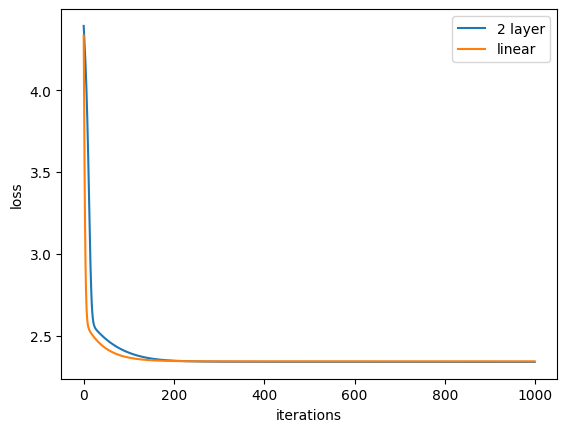

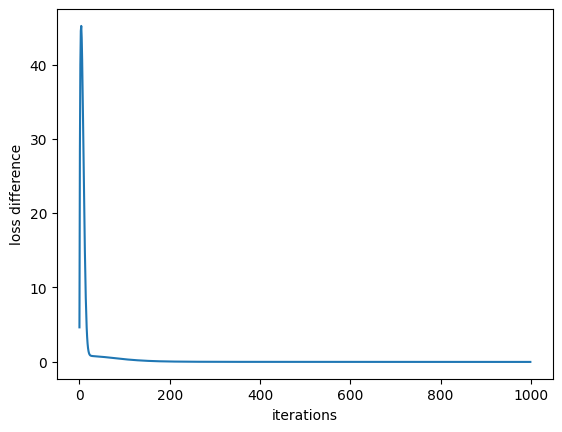

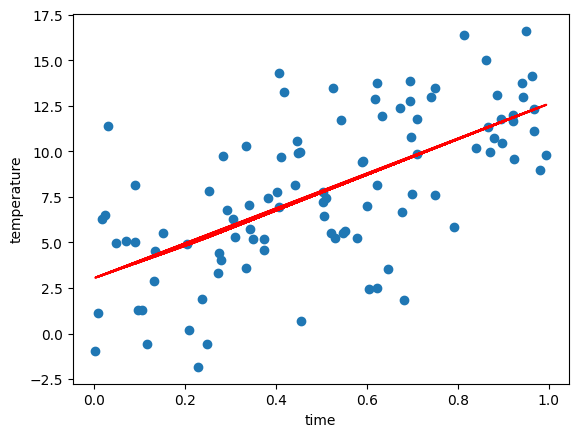

In [10]:
class nLayerModel(torch.nn.Module):
    def __init__(self, num_layers, hidden_size=128):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(1, hidden_size))
        for i in range(num_layers - 1):
            self.layers.append(torch.nn.Linear(hidden_size, hidden_size))
            self.layers.append(torch.nn.ReLU())
        self.layers.append(torch.nn.Linear(hidden_size, 1))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
model = nLayerModel(2)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
x_data_torch = torch.tensor(x_data).float()
y_data_torch = torch.tensor(y_data).float()
loss_tracker = []
for i in range(num_iters):
    y_pred = model(x_data_torch[:, None])
    loss = loss_fn(y_pred.squeeze(), y_data_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_tracker.append(loss.item())

plt.figure()
plt.plot(np.log(loss_tracker), label='2 layer')
plt.plot(np.log(linear_loss_tracker), label='linear')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()

plt.figure()
plt.plot(np.array(loss_tracker) - np.array(linear_loss_tracker))
plt.xlabel('iterations')
plt.ylabel('loss difference')

# now lets plot our predictions over the data
plot_data(x_data, y_data, lambda x: model(torch.tensor(x).float()[:, None]).detach().numpy())
    

Okay, but now note something weird! At some point, our neural network starts doing *better* than the linear regression model. Lets zoom in a bit to see this. How is this possible? Any guesses?

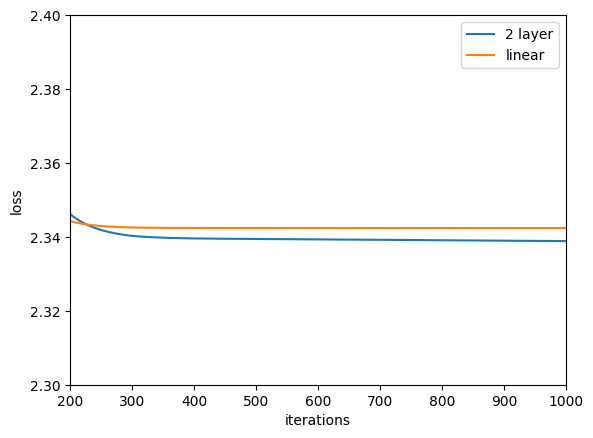

In [14]:
plt.figure()
plt.plot(np.log(loss_tracker), label='2 layer')
plt.plot(np.log(linear_loss_tracker), label='linear')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.xlim(200, 1000)
plt.ylim(2.3, 2.4)
plt.legend()